In [34]:
# Parameter Fitting of Kf_Uptake and Kf_Dissociation in both healthy and uremic conditions 
# Synthethic data generation

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Constants
V_Cell_Monolayer = 3.2e-07
V_Mem = 0.0032
V_Well = 0.0001
 
initial_OAT1 = 0.190962
initial_PCS_C = 0
initial_PCS_OAT1 = 0
Km_Efflux = 69
Kr_Uptake = 0.000
Kr_dissociation = 0.000
Vmax_Efflux = 0.0003986

# Variables
initial_PCS_B = 200
Kf_Uptake = 1.75e-05
Kf_dissociation = 4.18e-04

def model(t, Kf_Uptake, Kf_dissociation):

    y0 = [initial_PCS_B, initial_OAT1, initial_PCS_OAT1, initial_PCS_C]
    
    params = [Kf_Uptake, Kr_Uptake, Kf_dissociation, Kr_dissociation, Vmax_Efflux, Km_Efflux, V_Mem, V_Well, V_Cell_Monolayer]
    
    def odes(t, y):
        PCS_B, OAT1, PCS_OAT1, PCS_C = y
        Kf_Uptake, Kr_Uptake, Kf_dissociation, Kr_dissociation, Vmax_Efflux, Km_Efflux, V_Mem, V_Well, V_Cell_Monolayer = params
        
        dPCS_Bdt = (-((Kf_Uptake * OAT1 * PCS_B + (-Kr_Uptake * PCS_OAT1)) * V_Mem) + 
                    ((Vmax_Efflux * PCS_C) / (Km_Efflux + PCS_C)) * V_Mem) / V_Well
        
        dOAT1dt = (-((Kf_Uptake * OAT1 * PCS_B + (-Kr_Uptake * PCS_OAT1)) * V_Mem) + 
                   ((Kf_dissociation * PCS_OAT1 + (-Kr_dissociation * OAT1 * PCS_C)) * V_Mem)) / V_Mem
        
        dPCS_OAT1dt = (((Kf_Uptake * OAT1 * PCS_B + (-Kr_Uptake * PCS_OAT1)) * V_Mem) - 
                       ((Kf_dissociation * PCS_OAT1 + (-Kr_dissociation * OAT1 * PCS_C)) * V_Mem)) / V_Mem
        
        dPCS_Cdt = ((-(Vmax_Efflux * PCS_C) / (Km_Efflux + PCS_C) * V_Mem) + 
                    ((Kf_dissociation * PCS_OAT1 + (-Kr_dissociation * OAT1 * PCS_C)) * V_Mem)) / V_Cell_Monolayer
        
        return [dPCS_Bdt, dOAT1dt, dPCS_OAT1dt, dPCS_Cdt]

    solution = solve_ivp(odes, (t[0], t[-1]), y0, t_eval=t)
    
    return solution.y


In [35]:
# Define the time points for the experimental data (converted to minutes)
t_exp = np.array([50, 100, 200, 300, 500, 600, 750, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3600, 4200, 4800, 5000, 5300, 5900, 6300, 6900, 7500, 8000]) / 60  

PCS_B_sim, OAT1_sim, PCS_OAT1_sim, PCS_C_sim = model(t_exp * 60, Kf_Uptake, Kf_dissociation)

# Add noise to each species' simulated data
PCS_B_noisy = np.abs(PCS_B_sim + np.random.normal(0, noise_level_PCS_B, PCS_B_sim.shape))
OAT1_noisy = np.abs(OAT1_sim + np.random.normal(0, noise_level_OAT1, OAT1_sim.shape))
PCS_OAT1_noisy = np.abs(PCS_OAT1_sim + np.random.normal(0, noise_level_PCS_OAT1, PCS_OAT1_sim.shape))
PCS_C_noisy = np.abs(PCS_C_sim + np.random.normal(0, noise_level_PCS_C, PCS_C_sim.shape))

Fitted parameters:
Kf_Uptake = 1.935868489889137e-05
Kf_dissociation = 0.00040549926119583945


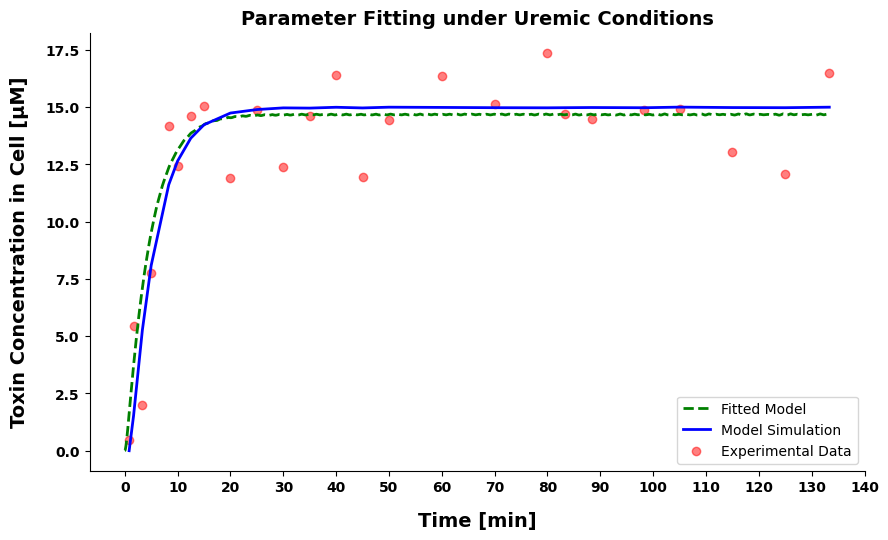

In [37]:
# Define the time points for the experimental data (converted to minutes)
t_exp = np.array([50, 100, 200, 300, 500, 600, 750, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3600, 4200, 4800, 5000, 5300, 5900, 6300, 6900, 7500, 8000]) / 60  

# Noise levels for species
noise_level_OAT1 = 0.019
noise_level_PCS_C = 1.5
noise_level_PCS_OAT1 = 0.0175
noise_level_PCS_B = 2

PCS_B_sim, OAT1_sim, PCS_OAT1_sim, PCS_C_sim = model(t_exp * 60, Kf_Uptake, Kf_dissociation)

# Add noise to each species' simulated data
PCS_B_noisy = np.abs(PCS_B_sim + np.random.normal(0, noise_level_PCS_B, PCS_B_sim.shape))
OAT1_noisy = np.abs(OAT1_sim + np.random.normal(0, noise_level_OAT1, OAT1_sim.shape))
PCS_OAT1_noisy = np.abs(PCS_OAT1_sim + np.random.normal(0, noise_level_PCS_OAT1, PCS_OAT1_sim.shape))
PCS_C_noisy = np.abs(PCS_C_sim + np.random.normal(0, noise_level_PCS_C, PCS_C_sim.shape))

# Perform the curve fitting
initial_guess = [Kf_Uptake, Kf_dissociation]
popt, pcov = curve_fit(
    lambda t, Kf_Uptake, Kf_dissociation: model(t * 60, Kf_Uptake, Kf_dissociation)[3, :],  # Select PCS_C species
    t_exp, 
    PCS_C_noisy, 
    p0=initial_guess
)

# Extract the best-fit parameters
best_Kf_Uptake, best_Kf_dissociation = popt

# Print the fitted parameters
print("Fitted parameters:")
print(f"Kf_Uptake = {best_Kf_Uptake}")
print(f"Kf_dissociation = {best_Kf_dissociation}")

# Simulate the model again with the fitted parameters
t_eval = np.linspace(0, 8000, 10000) / 60  # Full range of time for plotting in minutes
PCS_C_fitted = model(t_eval * 60, best_Kf_Uptake, best_Kf_dissociation)[3, :]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_eval, PCS_C_fitted, label='Fitted Model', color='green', linestyle='--', linewidth=2)
plt.plot(t_exp, PCS_C_sim, label='Model Simulation', color='blue', linestyle='-', linewidth=2)
plt.scatter(t_exp, PCS_C_noisy, label='Experimental Data', color='red', alpha=0.5)
plt.title('Parameter Fitting under Uremic Conditions', fontsize=14, fontweight='bold')
plt.xlabel('Time [min]', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Toxin Concentration in Cell [μM]', fontsize=14, fontweight='bold', labelpad=12)
plt.legend(loc='lower right')
plt.xticks(np.arange(0, max(t_eval)+10, 10), fontsize=10, fontweight='bold') 
plt.yticks(fontsize=10, fontweight='bold')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(bottom=0.15)  # Adjust this value as needed
plt.savefig(f'Curve_Fitting_Urem.png', dpi=300)
plt.show()


In [38]:
# Print the synthetic data points
print("Time (min)  PCS_B (noisy)  OAT1 (noisy)  PCS_OAT1 (noisy)  PCS_C (noisy)")
for i in range(len(t_exp)):
    print(f"{t_exp[i]:.2f}      {PCS_B_noisy[i]:.4f}       {OAT1_noisy[i]:.4f}        {PCS_OAT1_noisy[i]:.4f}       {PCS_C_noisy[i]:.4f}")


Time (min)  PCS_B (noisy)  OAT1 (noisy)  PCS_OAT1 (noisy)  PCS_C (noisy)
0.83      200.8066       0.2083        0.0227       0.4470
1.67      199.9862       0.1622        0.0383       5.4560
3.33      197.2208       0.1276        0.0886       1.9931
5.00      197.1002       0.0795        0.1145       7.7624
8.33      194.3142       0.0446        0.1571       14.1625
10.00      196.6404       0.0426        0.1682       12.4384
12.50      193.6992       0.0092        0.1648       14.6027
15.00      195.4943       0.0396        0.1818       15.0337
20.00      193.8574       0.0415        0.1701       11.9180
25.00      190.2272       0.0359        0.1624       14.8876
30.00      194.3076       0.0144        0.1484       12.3695
35.00      195.6299       0.0350        0.1726       14.5958
40.00      196.7902       0.0528        0.1641       16.3942
45.00      191.0498       0.0173        0.1542       11.9661
50.00      193.9951       0.0302        0.1517       14.4186
60.00      196.4904  